# 8. Heteroskedasticity
## 8.1 Heteroskedasticity-Robust Inference

|_reg.fit(option)_|Descrption|
|---|---|
|_reg.fit()_|default errors, assume homoskedasticity|
|_reg.fit(cov_type="HC0")_|Whites robust covariance matrix|
|_reg.fit(cov_type="HC1")_|White's robust covariance matrix corrected by degrees of freedom|
|_reg.fit(cov_type="HC2")_|small sample correction; STATA default|
|_reg.fit(cov_type="HC3")_|refined version of White's robust covariance matrix.|

$$ Var(u_i|x_i) = \sigma_i^2$$

$$\hat{\beta_1} = \beta_1 + \frac{\sum_{i=1}^{n}{(x_i - \bar{x})u_i}}{\sum_{i=1}^{n}{(x_i - \bar{x})^2}} $$

$$Var(\hat{\beta_1})=\frac{\sum_{i=1}^{n}{(x_i - \bar{x})^2  \sigma_i^2}}{{SST}_x^2} $$

### Example 8.2: Heteroskedasticity-Robust Inference



In [1]:
import wooldridge as woo
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats
from supplementaryFunctions import *

In [2]:
gpa3 = woo.dataWoo("gpa3")
formula = "cumgpa ~ sat + hsperc + tothrs + female + black + white"
reg = smf.ols(formula = formula, 
              data = gpa3,
             subset = gpa3["spring"] == 1)

# save results in dictionary
results = {}
results["default"] = reg.fit()
OLS_summary(results["default"])

,$\beta $,$t$,$$P>|t|$$,$SE$
$$r^2: 0.4006$$,,,,
Intercept,1.4701,6.3971,0.0000,0.2298
sat,0.0011,6.3885,0.0000,0.0002
hsperc,-0.0086,-6.9060,0.0000,0.0012
tothrs,0.0025,3.4255,0.0007,0.0007
female,0.3034,5.1412,0.0000,0.0590
black,-0.1283,-0.8705,0.3846,0.1474
white,-0.0587,-0.4165,0.6773,0.1410


In [3]:
# estimate model with White SE
results["White"] = reg.fit(cov_type="HC0")
OLS_summary(results["White"])

,$\beta $,$t$,$$P>|t|$$,$SE$
$$r^2: 0.4006$$,,,,
Intercept,1.4701,6.7261,0.0000,0.2186
sat,0.0011,6.0136,0.0000,0.0002
hsperc,-0.0086,-6.1001,0.0000,0.0014
tothrs,0.0025,3.4136,0.0006,0.0007
female,0.3034,5.1807,0.0000,0.0586
black,-0.1283,-1.0863,0.2774,0.1181
white,-0.0587,-0.5323,0.5945,0.1103


In [4]:
# estimate model with White SE
results["Refined"] = reg.fit(cov_type="HC3")
OLS_summary(results["Refined"])

,$\beta $,$t$,$$P>|t|$$,$SE$
$$r^2: 0.4006$$,,,,
Intercept,1.4701,6.4089,0.0000,0.2294
sat,0.0011,5.8402,0.0000,0.0002
hsperc,-0.0086,-5.9341,0.0000,0.0014
tothrs,0.0025,3.3418,0.0008,0.0007
female,0.3034,5.0539,0.0000,0.0600
black,-0.1283,-1.0007,0.3170,0.1282
white,-0.0587,-0.4876,0.6258,0.1204


In [5]:
ftests = {}
hypotheses = ["black = 0", "white = 0"]
for key, result in results.items():
    ftest = result.f_test(hypotheses)
    ftests[key] = {}
    ftests[key]["F-stat"] = ftest.statistic
    ftests[key]["p-value"] = ftest.pvalue

pd.DataFrame(ftests)

,default,White,Refined
F-stat,0.679604,0.747797,0.672469
p-value,0.507468,0.474144,0.511088


# 8.2. Heteroskedasticity Tests
### Breusch-Pagan Test


### Example 8.4: Heteroskedasticity in a Housing Price Equation

In [6]:
hprice1 = woo.dataWoo("hprice1")
formula = "price ~ lotsize + sqrft + bdrms"
reg = smf.ols(formula = formula,
             data = hprice1)
results = reg.fit()
OLS_summary(results)

,$\beta $,$t$,$$P>|t|$$,$SE$
$$r^2: 0.6724$$,,,,
Intercept,-21.7703,-0.7386,0.4622,29.4750
lotsize,0.0021,3.2201,0.0018,0.0006
sqrft,0.1228,9.2751,0.0000,0.0132
bdrms,13.8525,1.5374,0.1279,9.0101


In [7]:
bp_results = {}
bp_results["Manual"] = {}
names = ["price", "lotsize","sqrft", "bdrms"]
X, y = build_X_y_matrices(hprice1, names)
hprice1["resid_sq"] = results.resid ** 2
reg_resid = sm.OLS(hprice1[["resid_sq"]], X)
results_resid = reg_resid.fit()

bp_results["Manual"]["F-stat"] = results_resid.fvalue
bp_results["Manual"]["F-pval"] = results_resid.f_pvalue
bp_results["Manual"]["LM"] = results_resid.rsquared * results_resid.nobs
dof = results_resid.df_model
bp_results["Manual"]["LM-pval"] = 1 - stats.chi2.cdf(bp_results["Manual"]["LM"], dof)
pd.DataFrame(bp_results)

C:\Users\JLCat\GithubRepositories\OtherRepositories\Wooldridge\supplementaryFunctions.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["Intercept"] = 1


,Manual
F-pval,0.002048
F-stat,5.338919
LM,14.092386
LM-pval,0.002782


In [8]:
# canned BP Test
bp_results["Auto"] = {}
results_bp_lm = sm.stats.diagnostic.het_breuschpagan(results.resid, X)
bp_results["Auto"]["LM"] = results_bp_lm[0]
bp_results["Auto"]["LM-pval"] = results_bp_lm[1]
bp_results["Auto"]["F-stat"] = results_bp_lm[2]
bp_results["Auto"]["F-pval"] = results_bp_lm[3]
pd.DataFrame(bp_results)

,Manual,Auto
F-stat,5.338919,5.338919
F-pval,0.002048,0.002048
LM,14.092386,14.092386
LM-pval,0.002782,0.002782


### Example 8.5: BP and White Test int he Log Housing Price Equation

In [9]:
hprice1 = woo.dataWoo("hprice1")
formula = "np.log(price) ~ np.log(lotsize) + np.log(sqrft) + bdrms"

reg = smf.ols(formula = formula,
             data = hprice1)
results = reg.fit()
names = ["price", "lotsize", "sqrft", "bdrms"]
log_vars = ["price","lotsize", "sqrft"]
X_bp, y = build_X_y_matrices(data = hprice1, 
                          names = names, 
                          log_vars = log_vars)
tests_dct = {"Breusch-Pagan":{}, "White":{}}
result_bp = sm.stats.diagnostic.het_breuschpagan(results.resid, X_bp)
tests_dct["Breusch-Pagan"]["statistic"] = result_bp[0]
tests_dct["Breusch-Pagan"]["p-val"] = result_bp[1]

X_wh = pd.DataFrame(({"const":1, 
         "fitted_reg": results.fittedvalues,
        "fitted_reg_sq": results.fittedvalues ** 2}))
result_white = sm.stats.diagnostic.het_breuschpagan(results.resid, X_wh)
tests_dct["White"]["statistic"] = result_white[0]
tests_dct["White"]["p-val"] = result_white[1]
pd.DataFrame(tests_dct)

C:\Users\JLCat\GithubRepositories\OtherRepositories\Wooldridge\supplementaryFunctions.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["Intercept"] = 1


,Breusch-Pagan,White
statistic,4.223246,3.447287
p-val,0.238345,0.178415


## 8.3 Weighted Least Squares

### Example 8.6: Financial Wealth Equation

In [10]:
k401ksubs = woo.dataWoo("401ksubs")
k401ksubs_sub = k401ksubs[k401ksubs["fsize"] == 1]

# OLS using only data for singles
formula = "nettfa ~ inc + I((age - 25)**2) + male + e401k"
reg_ols = smf.ols(formula = formula,
                 data = k401ksubs_sub)
results_ols = reg_ols.fit(cov_type = "HC0")

OLS_summary(results_ols)

,$\beta $,$t$,$$P>|t|$$,$SE$
$$r^2: 0.1279$$,,,,
Intercept,-20.9850,-6.0114,0.0000,3.4909
inc,0.7706,7.7486,0.0000,0.0994
I((age - 25) ** 2),0.0251,5.7912,0.0000,0.0043
male,2.4779,1.2053,0.2281,2.0558
e401k,6.8862,3.0153,0.0026,2.2837


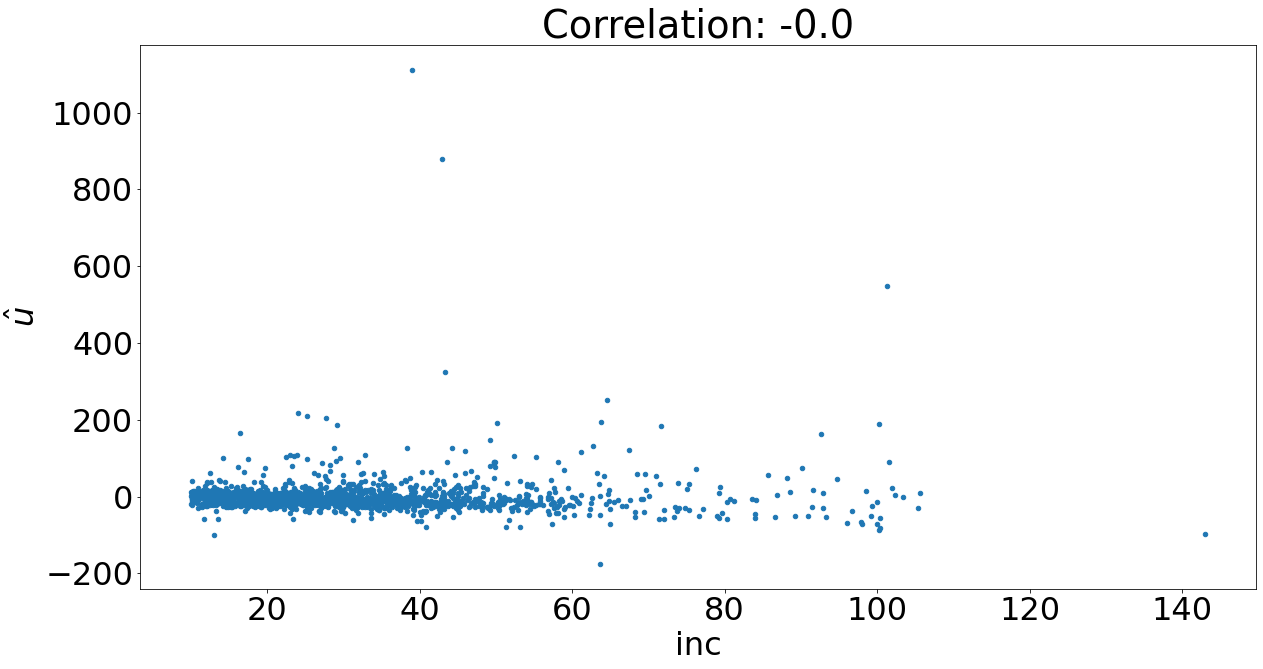

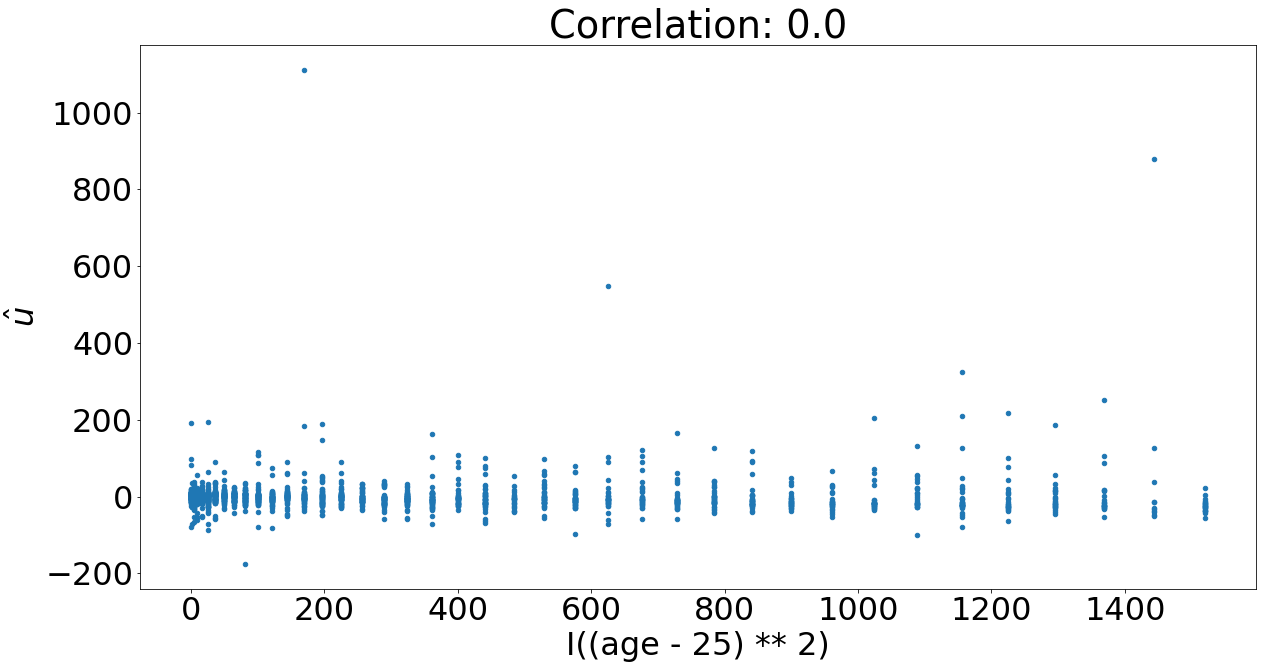

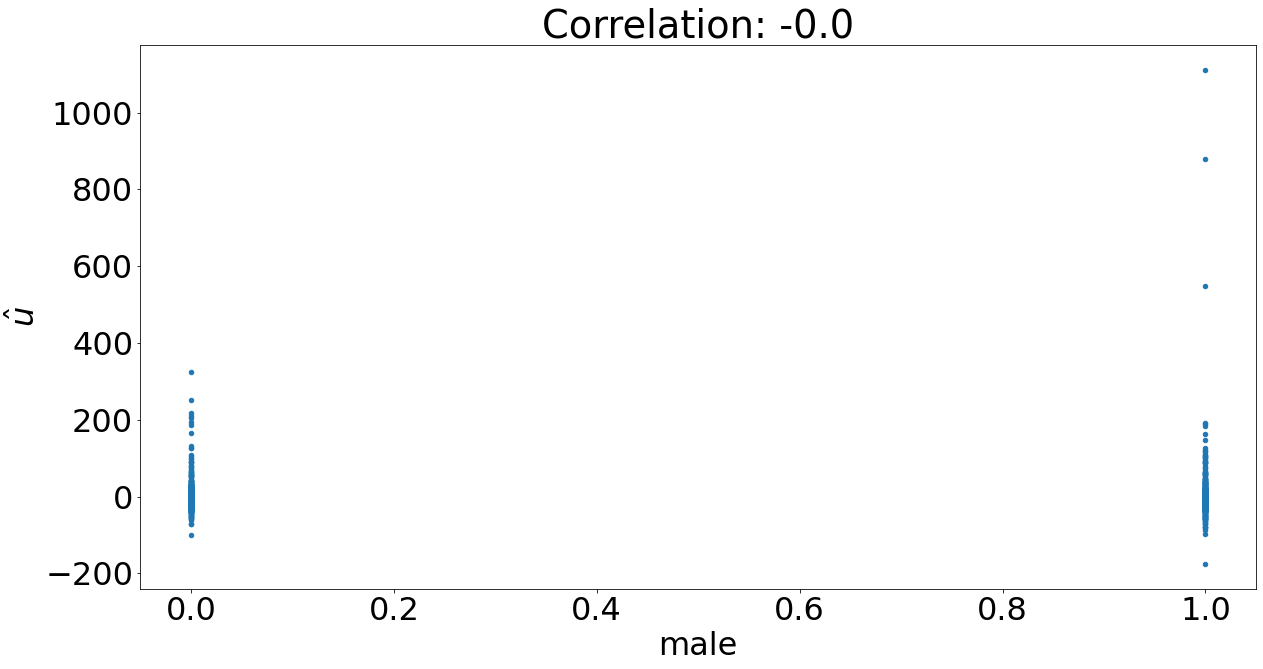

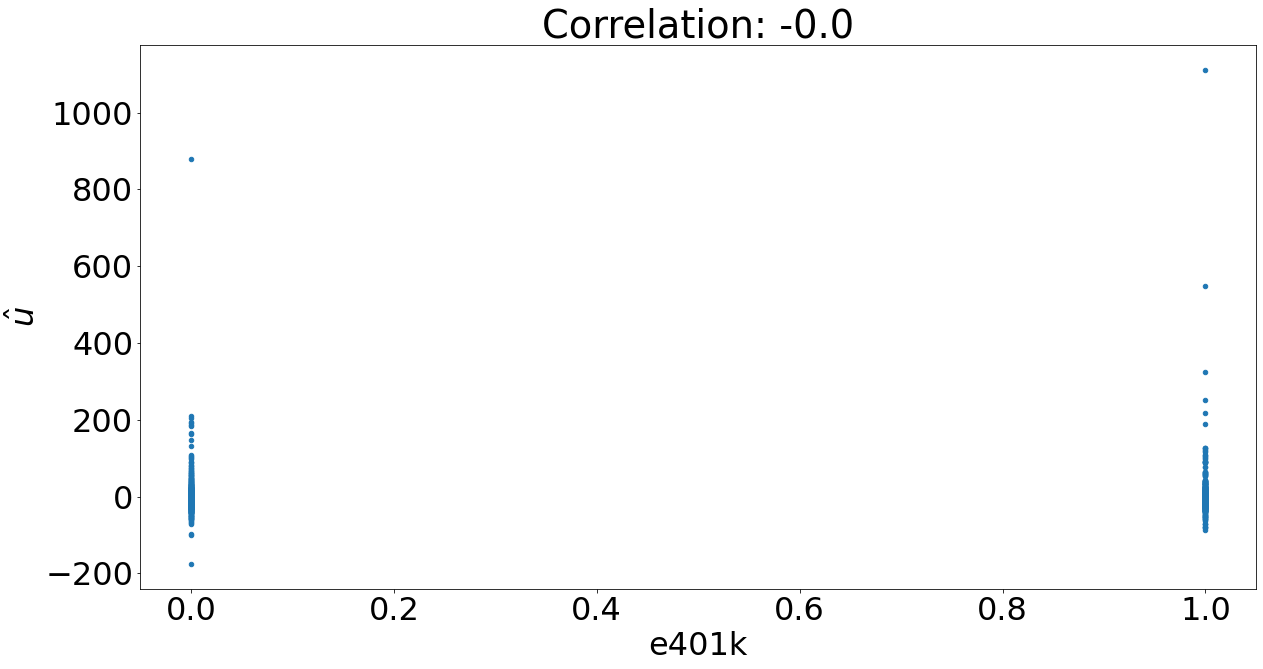

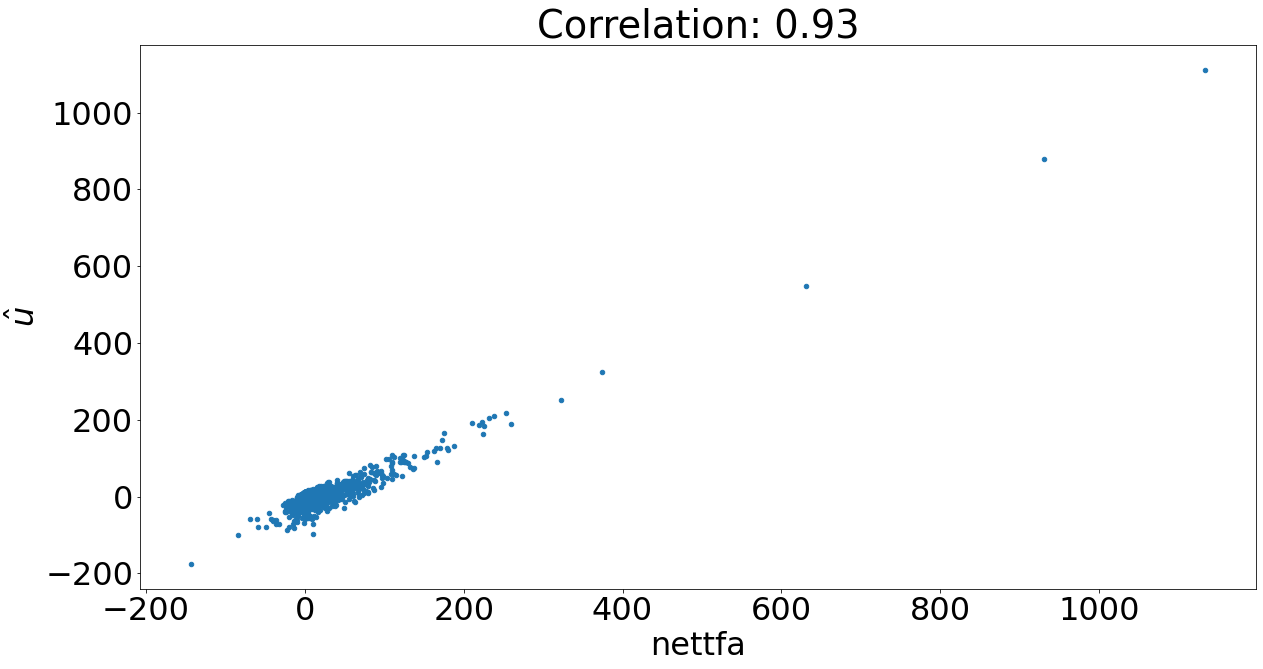

In [11]:
y, data = reg_ols.data.orig_endog, reg_ols.data.orig_exog
data[y.keys()] = y
plt.rcParams.update({"font.size":32})
build_estimator(data, results_ols, "nettfa")
plot_errors(data)

In [12]:
# WLS:
wls_weight = k401ksubs_sub["inc"].pow(-1)
reg_wls = smf.wls(formula = formula,
                 weights = wls_weight,
                 data = k401ksubs_sub)
results_wls = reg_wls.fit()
OLS_summary(results_wls)

,$\beta $,$t$,$$P>|t|$$,$SE$
$$r^2: 0.1115$$,,,,
Intercept,-16.7025,-8.5304,0.0000,1.9580
inc,0.7404,11.5140,0.0000,0.0643
I((age - 25) ** 2),0.0175,9.0796,0.0000,0.0019
male,1.8405,1.1771,0.2393,1.5636
e401k,5.1883,3.0458,0.0024,1.7034


#### Use robust standard errors for the WLS results.

In [13]:
# Everything matches results from book except SE
results_white = reg_wls.fit(cov_type = "HC3")
OLS_summary(results_white)

,$\beta $,$t$,$$P>|t|$$,$SE$
$$r^2: 0.1115$$,,,,
Intercept,-16.7025,-7.4292,0.0000,2.2482
inc,0.7404,9.8403,0.0000,0.0752
I((age - 25) ** 2),0.0175,6.7650,0.0000,0.0026
male,1.8405,1.4015,0.1611,1.3132
e401k,5.1883,3.2955,0.0010,1.5743


### Example 8.7: Demand for Cigarettes

In [14]:
smoke = woo.dataWoo("smoke")
formula = "cigs ~ np.log(income) + np.log(cigpric) + educ + age + I(age**2) + restaurn"
reg_ols = smf.ols(formula = formula,
                 data = smoke)
results_ols = reg_ols.fit()
OLS_summary(results_ols)

,$\beta $,$t$,$$P>|t|$$,$SE$
$$r^2: 0.0527$$,,,,
Intercept,-3.6398,-0.1512,0.8799,24.0787
np.log(income),0.8803,1.2095,0.2268,0.7278
np.log(cigpric),-0.7509,-0.1301,0.8966,5.7733
educ,-0.5015,-3.0016,0.0028,0.1671
age,0.7707,4.8132,0.0000,0.1601
I(age ** 2),-0.0090,-5.1765,0.0000,0.0017
restaurn,-2.8251,-2.5410,0.0112,1.1118


In [15]:
y, X = reg_ols.data.orig_endog, reg_ols.data.orig_exog
result_bp = sm.stats.diagnostic.het_breuschpagan(results_ols.resid, X)
tests_dct = {}
tests_dct["Breusch-Pagan"] = {}
tests_dct["Breusch-Pagan"]["statistic"] = result_bp[0]
tests_dct["Breusch-Pagan"]["p-val"] = result_bp[1]
pd.DataFrame(tests_dct)

,Breusch-Pagan
p-val,0.000015
statistic,32.258419


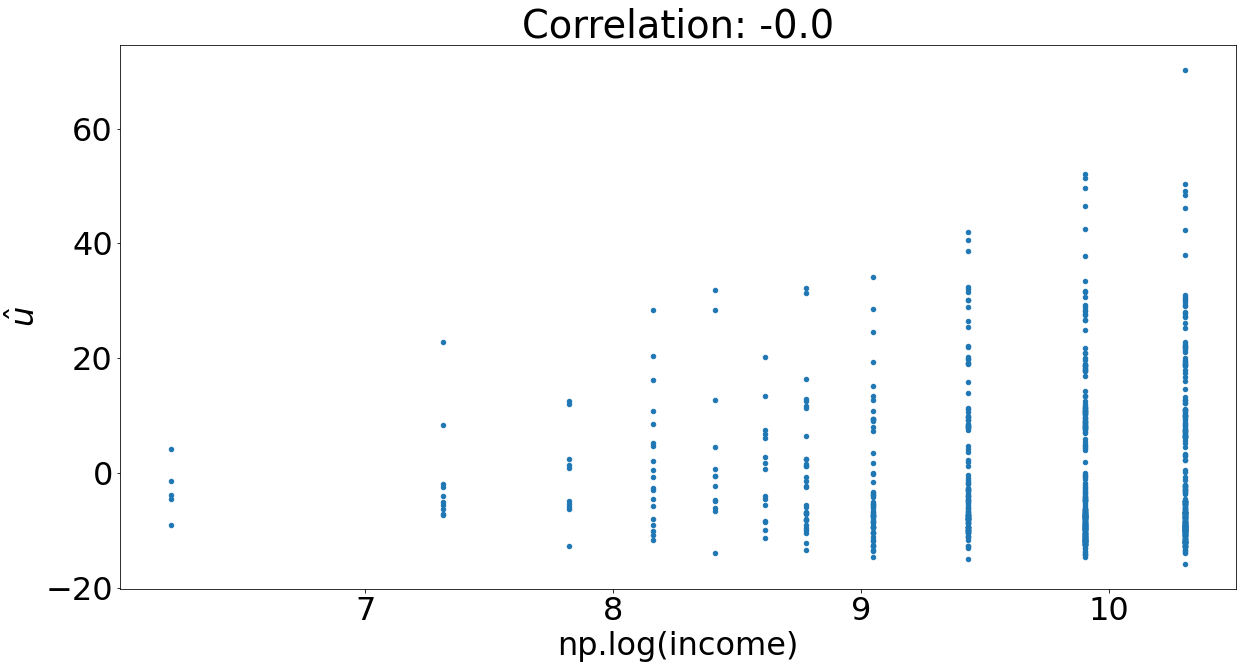

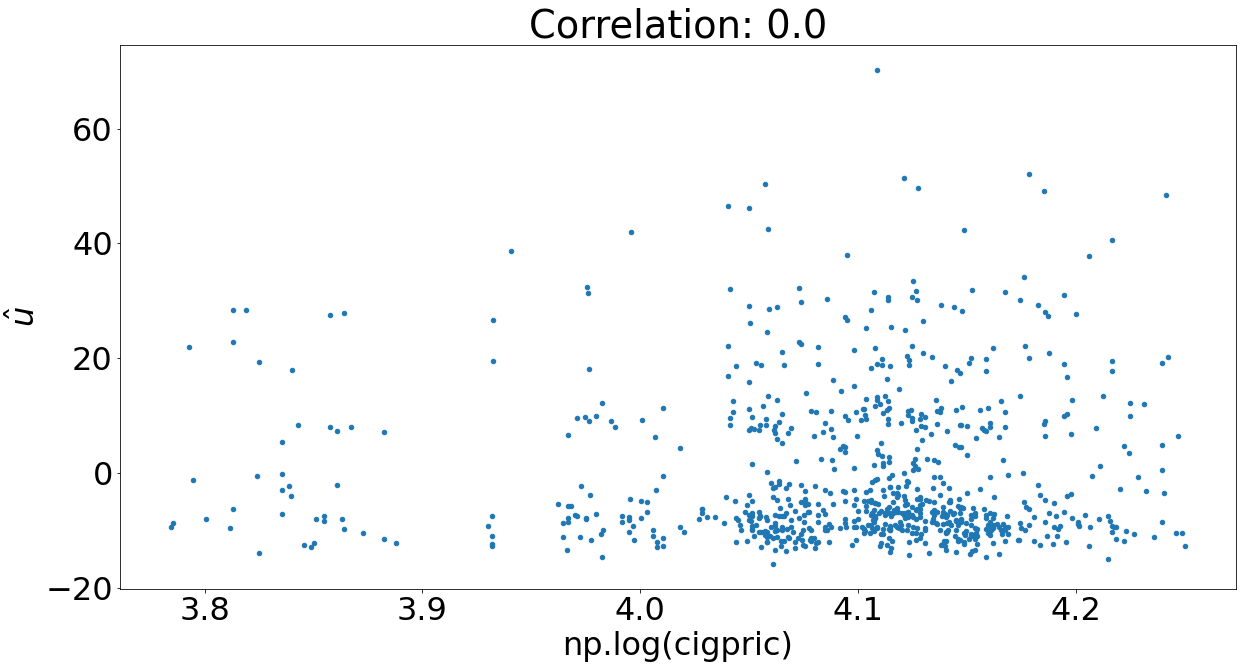

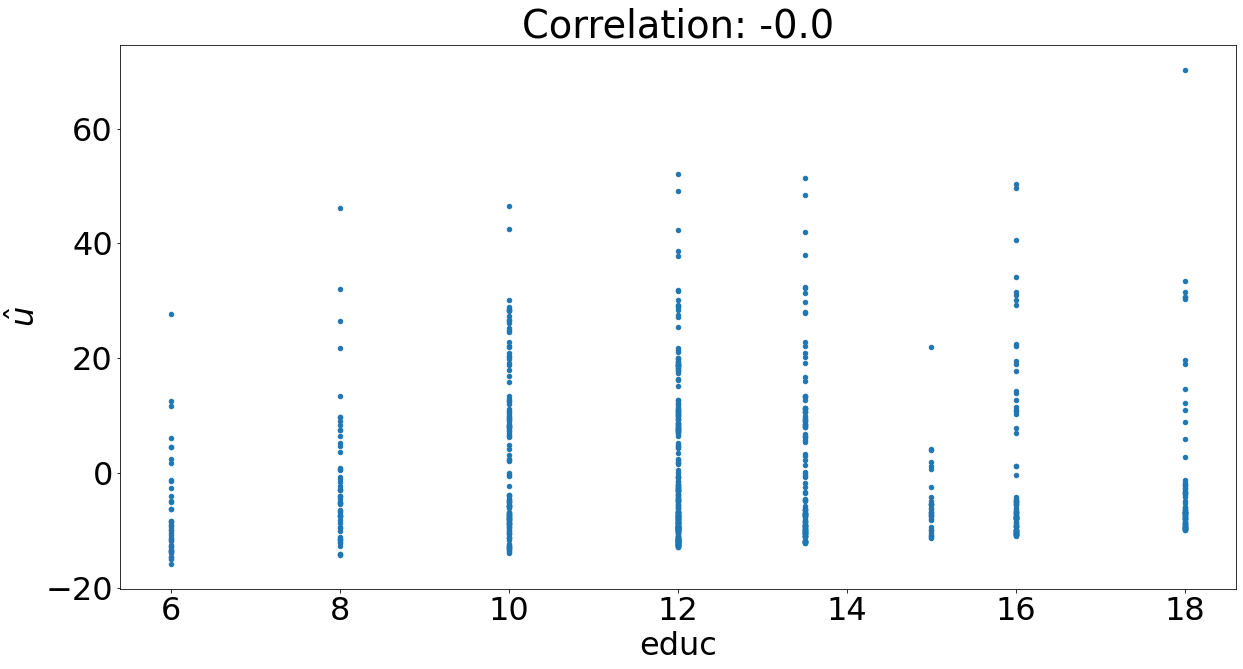

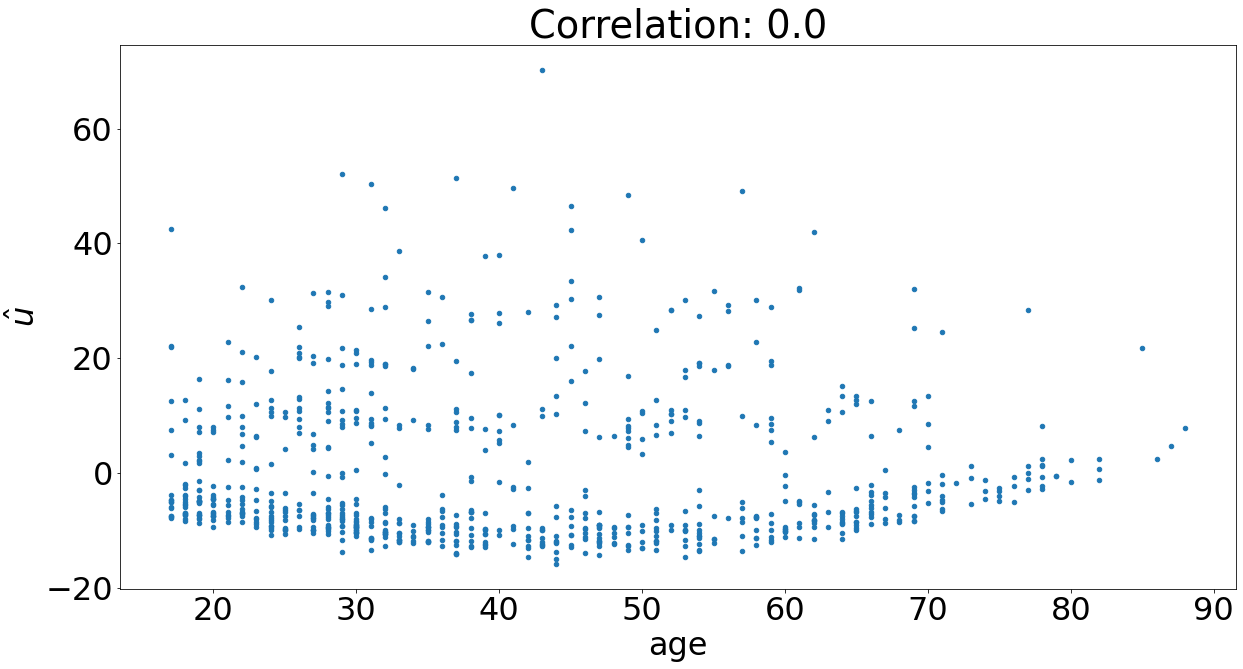

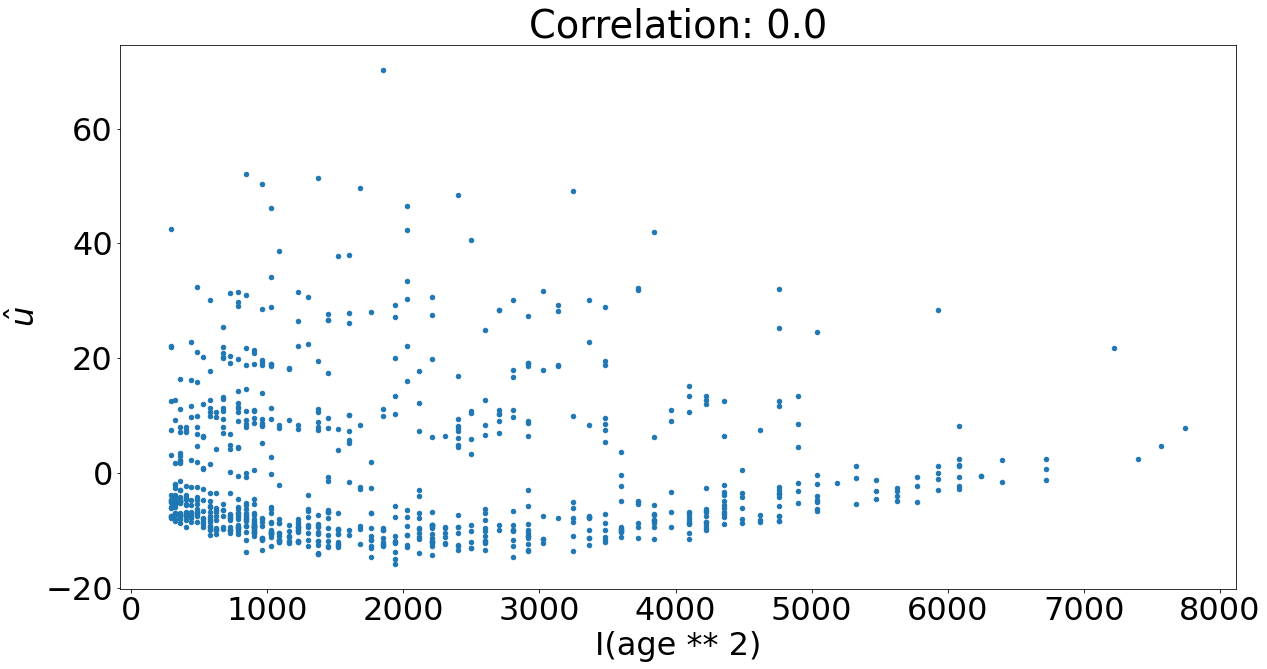

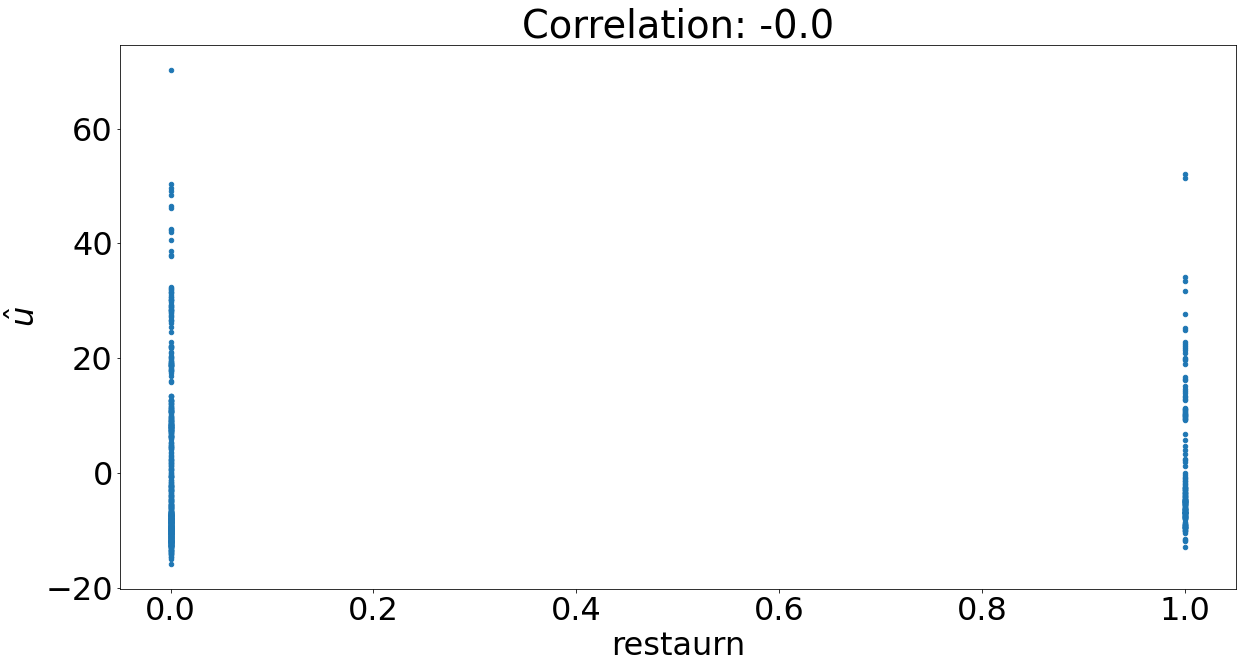

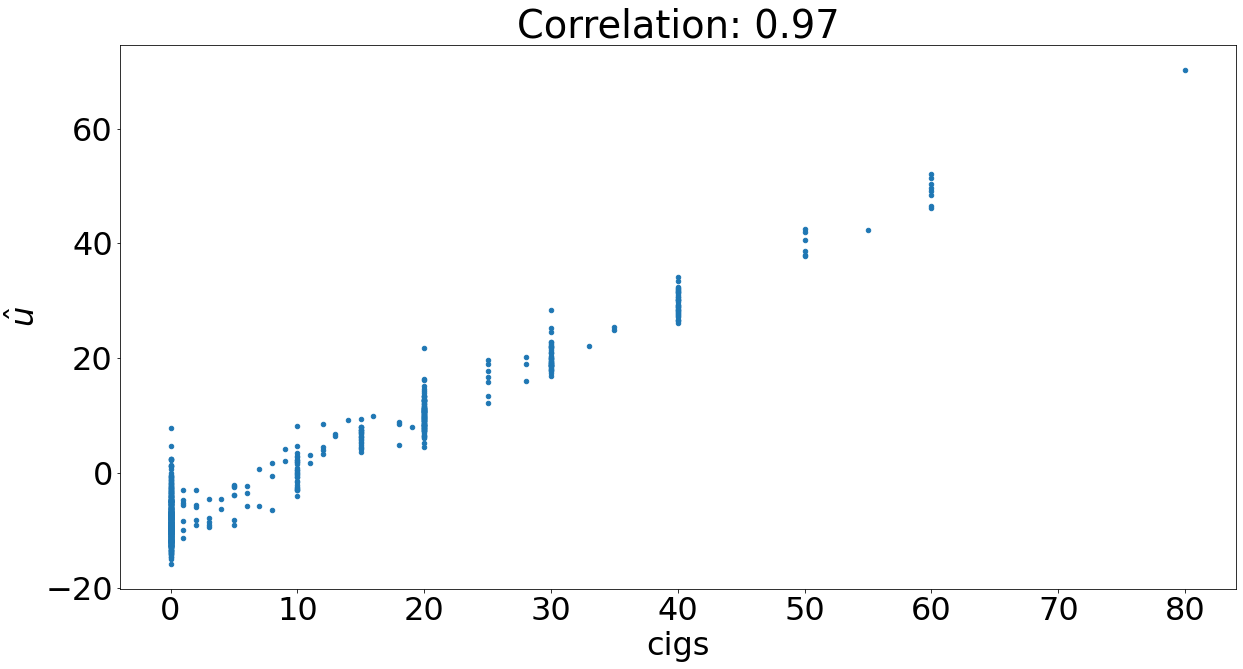

In [16]:
data = X
data[y.keys()] = y
plt.rcParams.update({"font.size":32})
build_estimator(data, results_ols, "cigs")
plot_errors(data)

In [17]:
#FGLS (estimation of the variance function)
fgls_dep = "logu2"
smoke[fgls_dep] = np.log(results_ols.resid**2)
fgls_formula = formula.replace("cigs", fgls_dep) 
reg_fgls = smf.ols(formula = fgls_formula,
                  data = smoke)
results_fgls = reg_fgls.fit()
OLS_summary(results_fgls)

,$\beta $,$t$,$$P>|t|$$,$SE$
$$r^2: 0.2474$$,,,,
Intercept,-1.9207,-0.7494,0.4538,2.5630
np.log(income),0.2915,3.7634,0.0002,0.0775
np.log(cigpric),0.1954,0.3180,0.7506,0.6145
educ,-0.0797,-4.4817,0.0000,0.0178
age,0.2040,11.9693,0.0000,0.0170
I(age ** 2),-0.0024,-12.8931,0.0000,0.0002
restaurn,-0.6270,-5.2982,0.0000,0.1183


In [18]:
#FGLS (WLS):
wls_weight = np.exp(results_fgls.fittedvalues).pow(-1)
reg_wls = smf.wls(formula = formula,
                  weights = wls_weight,
                 data = smoke)
results_wls = reg_wls.fit()
OLS_summary(results_wls)


,$\beta $,$t$,$$P>|t|$$,$SE$
$$r^2: 0.1134$$,,,,
Intercept,5.6355,0.3165,0.7517,17.8031
np.log(income),1.2952,2.9639,0.0031,0.4370
np.log(cigpric),-2.9403,-0.6592,0.5099,4.4601
educ,-0.4634,-3.8570,0.0001,0.1202
age,0.4819,4.9784,0.0000,0.0968
I(age ** 2),-0.0056,-5.9897,0.0000,0.0009
restaurn,-3.4611,-4.3508,0.0000,0.7955


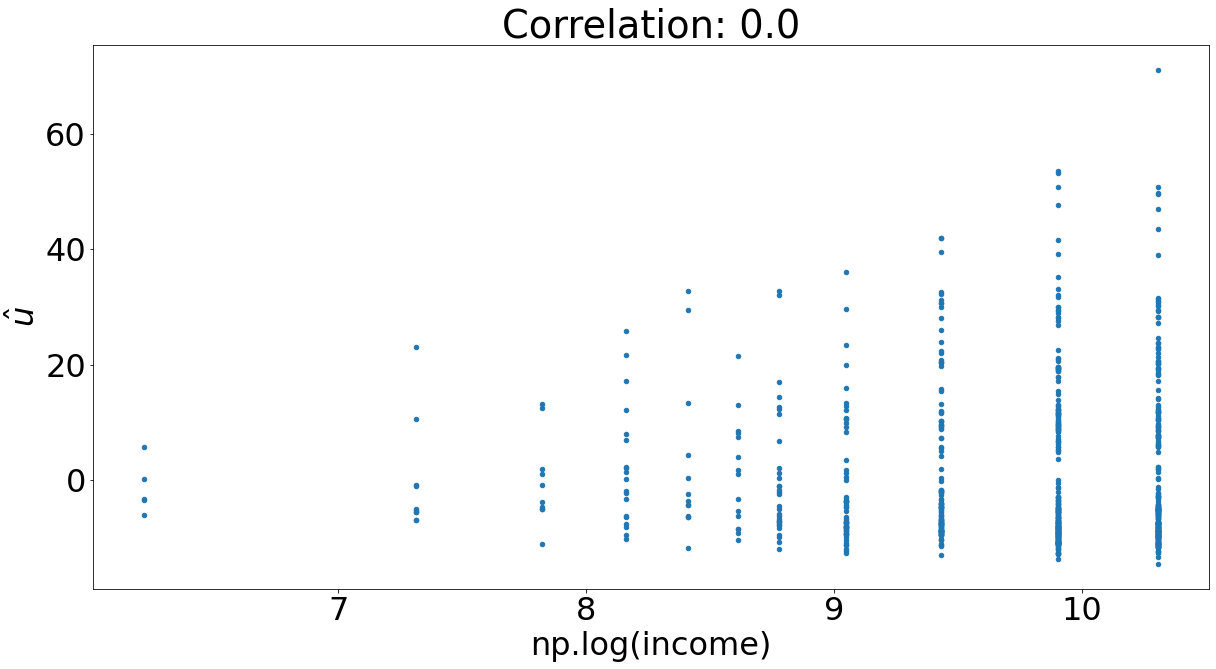

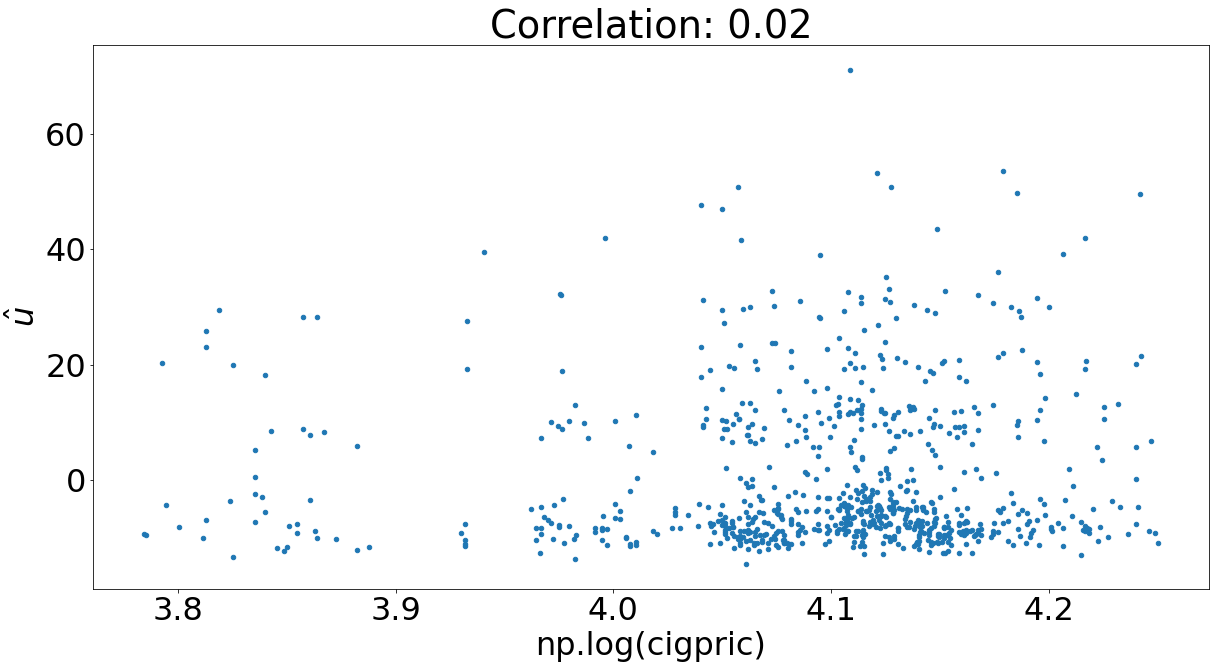

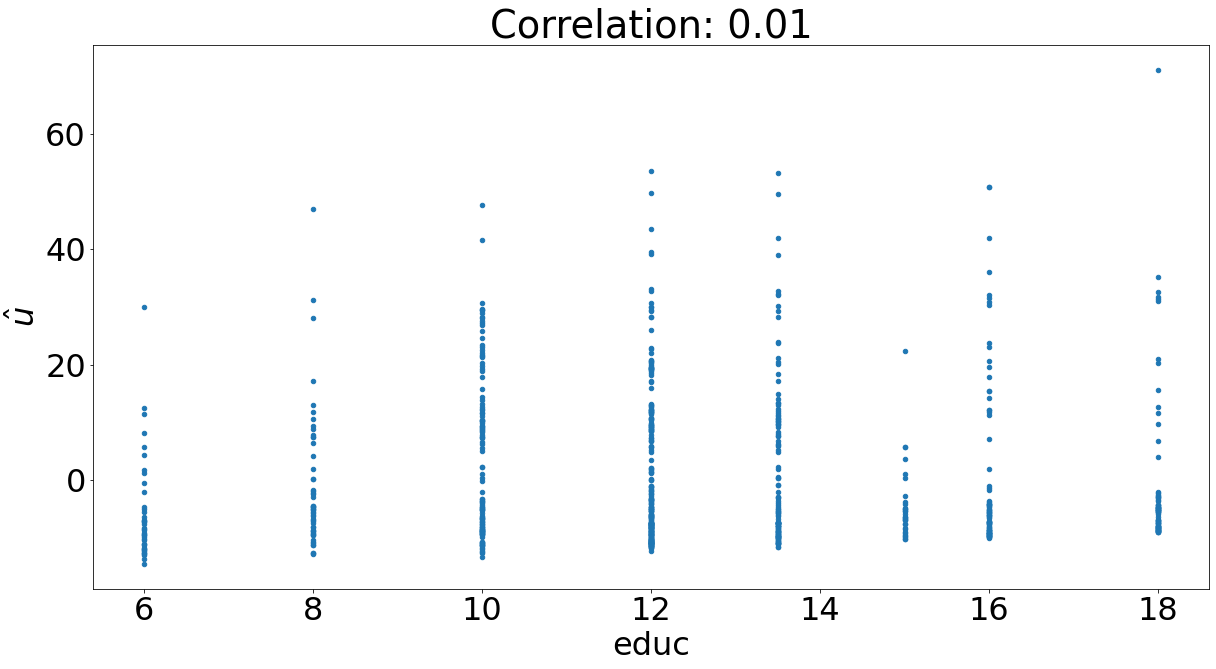

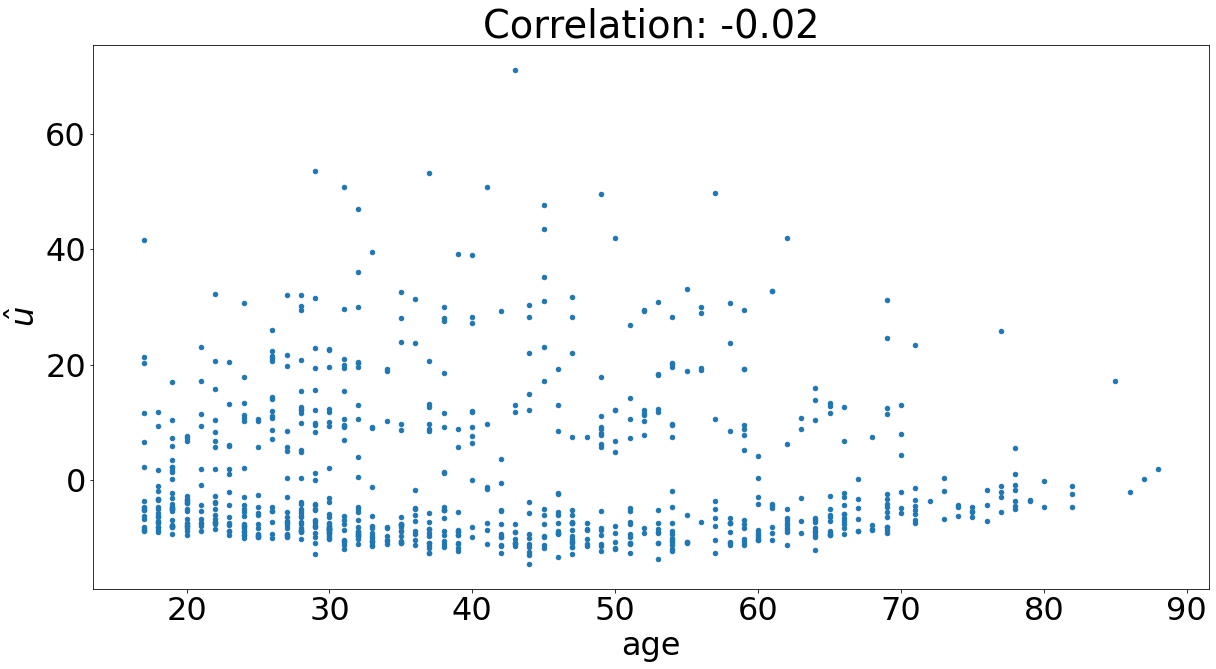

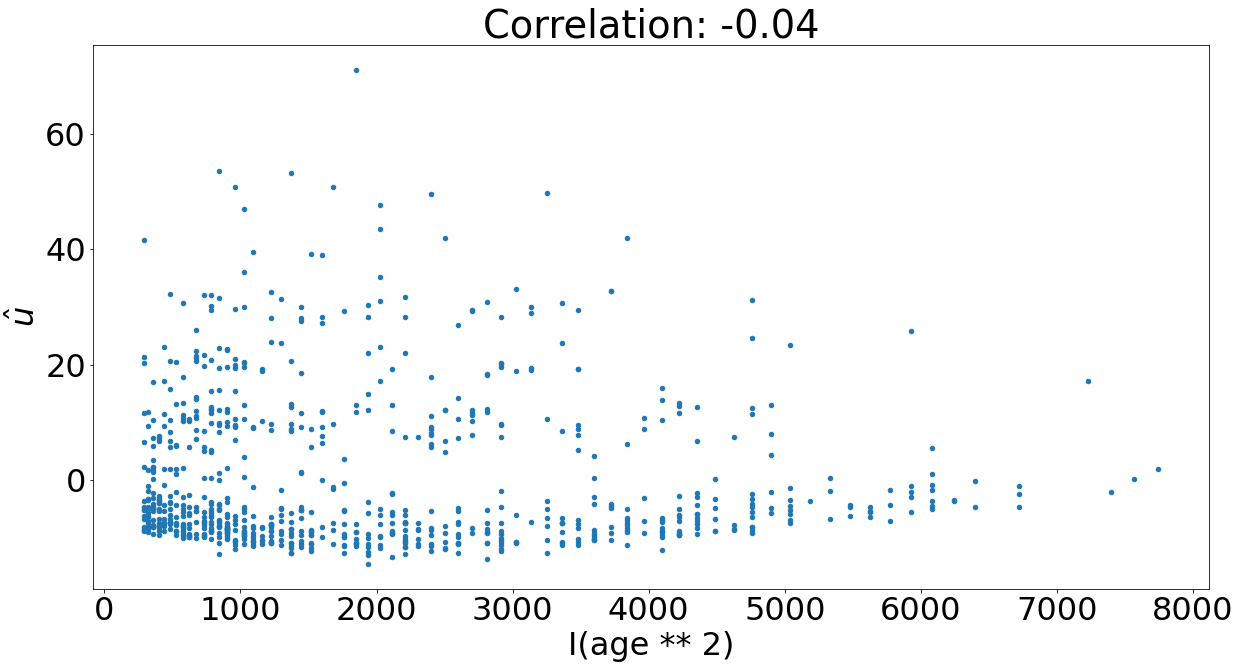

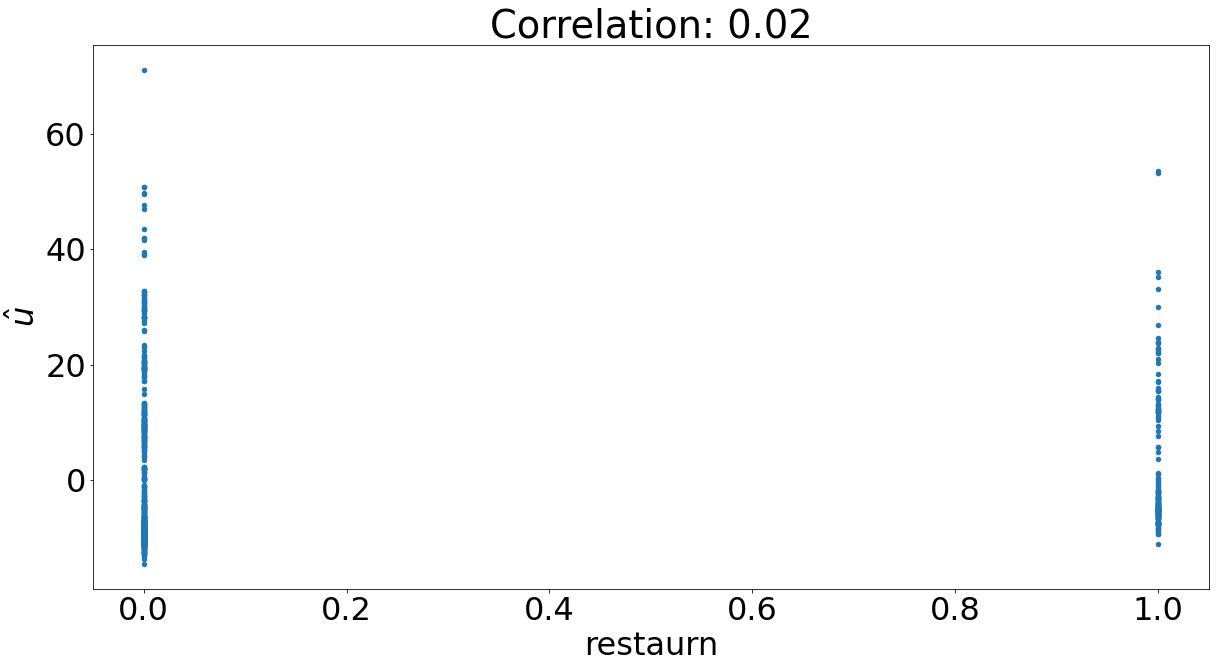

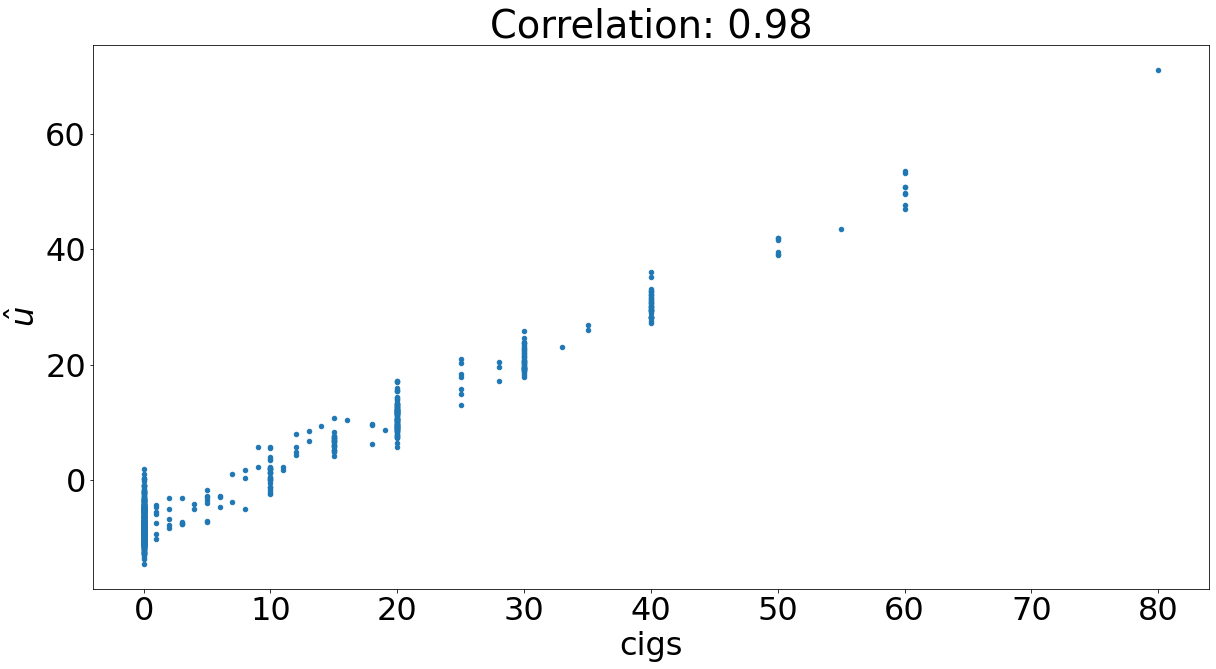

In [19]:
y, data = reg_wls.data.orig_endog, reg_wls.data.orig_exog
data[y.keys()] = y
plt.rcParams.update({"font.size":32})
build_estimator(data, results_wls, "cigs")
plot_errors(data)